In [2]:
import json
import random
import itertools
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import category_encoders
import hashlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.feature_extraction import FeatureHasher
from tensorflow.keras.callbacks import EarlyStopping


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
def encode_time(original_dataframe: pd.DataFrame, columns_to_encode: list[str], period: int) -> pd.DataFrame:
    for column in columns_to_encode:
        original_dataframe[column] = original_dataframe[column].astype('float64')
        original_dataframe[column + '_sin'] = np.sin(2 * np.pi * original_dataframe[column] / period)
        original_dataframe[column + '_cos'] = np.cos(2 * np.pi * original_dataframe[column] / period)
    original_dataframe = original_dataframe.drop(columns=columns_to_encode)
    return original_dataframe

def encode_time_utc(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    timestamps = []
    for i in range(len(original_dataframe)):
        time_stamp = original_dataframe.loc[i, column_to_encode]
        if time_stamp.__contains__("."):
            pattern = '%Y-%m-%dT%H:%M:%S.%fZ'
        else: 
            pattern = '%Y-%m-%dT%H:%M:%SZ'
        time_stamp = datetime.strptime(original_dataframe.loc[i, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe

def encode_time_local(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    timestamps = []
    for i in range(len(original_dataframe)):
        time_stamp = original_dataframe.loc[i, column_to_encode]
        if time_stamp.__contains__("."):
            pattern = '%Y-%m-%dT%H:%M:%S.%f'
        else: 
            pattern = '%Y-%m-%dT%H:%M:%S'
        time_stamp = datetime.strptime(original_dataframe.loc[i, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe


def number_of_unique_values_per_column(dataframe: pd.DataFrame) -> None:
    print([(column, dataframe[column].nunique()) for column in dataframe.columns])

def onehot_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    encoder = OneHotEncoder()
    encoded_column = encoder.fit_transform(original_dataframe[[column_to_encode]])
    encoded_column_dataframe = pd.DataFrame(encoded_column.toarray(), columns=encoder.get_feature_names_out([column_to_encode]))
    original_dataframe = pd.concat([original_dataframe, encoded_column_dataframe], axis=1)
    if column_to_encode != "session_id":
        original_dataframe = original_dataframe.drop(columns=[column_to_encode])
    return original_dataframe

def encode_classification(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    label_encoder = LabelEncoder()
    original_dataframe[column_to_encode] = label_encoder.fit_transform(original_dataframe[column_to_encode])
    return original_dataframe

def encode_boolean(original_dataframe: pd.DataFrame, columns_to_encode: list[str]) -> pd.DataFrame:
    for index in range(0, len(columns_to_encode)):
        original_dataframe[columns_to_encode[index]] = original_dataframe[columns_to_encode[index]].astype('int')
    return original_dataframe

def category_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    binary_encoder = category_encoders.BinaryEncoder(cols=column_to_encode)
    original_dataframe = binary_encoder.fit_transform(original_dataframe)
    return original_dataframe

def encode_str_to_enum(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    encoding_dict = dict()
    encoded_value = 0
    for index in range(len(original_dataframe)):
        value = original_dataframe.iloc[index][column_to_encode]
        if value in encoding_dict:
            original_dataframe.at[index, column_to_encode] = encoding_dict[value]
        else: 
            encoding_dict[value] = encoded_value
            original_dataframe.at[index, column_to_encode] = encoded_value
            encoded_value += 1
    return original_dataframe

def move_column_to_the_front(original_dataframe: pd.DataFrame, column_to_move: str) -> pd.DataFrame:
    first_column = original_dataframe.pop(column_to_move)
    original_dataframe.insert(0, column_to_move, first_column)
    return original_dataframe

In [12]:
# read json data
with open("datasets\\transfer\\smaller_dataset.json") as file:
    parsed_json = json.load(file)

# build dataframe 
total_amount_of_rows = 0
all_sessions = pd.DataFrame()
for i in pd.json_normalize(parsed_json['traces']):
    total_amount_of_rows += len(pd.json_normalize(parsed_json['traces'][i]))
    single_session = pd.json_normalize(parsed_json['traces'][i])
    #single_session_filtered = single_session.dropna(how='all', axis=1)
    #dropped_columns = set(single_session.columns) - set(single_session_filtered.columns)
    #print("Dropped columns:", dropped_columns)
    all_sessions = pd.concat([all_sessions, single_session], ignore_index=True)

all_sessions = all_sessions.drop(columns=['weather_day_id', 'weather_hour_id'])
number_of_unique_values_per_column(all_sessions)
all_sessions = all_sessions.drop(columns=['weather_future_day_id', 'weather_future_hour_id'])

all_sessions = all_sessions.infer_objects(copy=False)

null_columns = all_sessions.columns[all_sessions.isnull().any()]
for column in null_columns:
    all_sessions[column] = all_sessions[column].fillna(all_sessions[column].mode()[0])

null_columns = all_sessions.columns[all_sessions.isnull().any()]

unique_classifications = all_sessions['content_id'].unique()
#print(len(unique_classifications))

all_sessions = encode_time(all_sessions, ['time_hod'], 24)
all_sessions = encode_time(all_sessions, ['time_dow'], 7)
all_sessions = encode_time_utc(all_sessions, 'time_utc', '%Y-%m-%dT%H:%M:%SZ')
all_sessions = encode_time_local(all_sessions, 'time_local', '%Y-%m-%dT%H:%M:%S.%f')
all_sessions = encode_classification(all_sessions, 'content_id')
all_sessions = encode_classification(all_sessions, 'session_id')
all_sessions = encode_boolean(all_sessions, ['device_online'])

numerical_features = ['time_utc', 'time_local', 'device_height_px', 'device_width_px']
categorical_features = ['oha_layout', 'oha_language_iso2', 'device_country_iso2', 'device_language_iso2', 'content_portal', 'event_type', 'device_platform', 'device_id']
number_of_unique_values_per_column(all_sessions)

scaler = StandardScaler()
for column in numerical_features:
    all_sessions[column] = scaler.fit_transform(np.array(all_sessions[column]).reshape(-1, 1))

one_hot_encoder = OneHotEncoder()
for column in categorical_features:
    #all_sessions = onehot_encode_column(all_sessions, column)
    all_sessions = encode_classification(all_sessions, column)

#print(all_sessions.iloc[0])

# build features vectors
feature_vectors = []
for i in range(0, len(all_sessions)):
    if i < len(all_sessions) - 1:
        if all_sessions.iloc[i]['session_id'] == all_sessions.iloc[i+1]['session_id']:
            feature_vector = (all_sessions.iloc[i], all_sessions.iloc[i+1]['content_id']) 
            #feature_vector = (all_sessions.iloc[i].drop('session_id'), all_sessions.iloc[i+1]['content_id']) 
            feature_vectors.append(feature_vector)
        else:
            pass
            #feature_vector = (all_sessions.iloc[i].drop('session_id'), 39) 
            #feature_vector = (all_sessions.iloc[i], 39) 
            #feature_vectors.append(feature_vector)


''' 
# shuffle dataset
#random.shuffle(feature_vectors)

# build train / test sets
input_features = []
classification_labels = []

for input_feature, classification in feature_vectors:
    input_features.append(input_feature)
    classification_labels.append(classification)

X_train, X_test, y_train, y_test = train_test_split(input_features, classification_labels, test_size=0.2, random_state=42)
X_train = np.asarray([series.to_numpy().astype(np.float32) for series in X_train])
X_test = np.asarray([series.to_numpy().astype(np.float32) for series in X_test])
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
'''


'''
# encode columns
all_sessions = onehot_encode_column(all_sessions, 'device_id')
all_sessions = encode_boolean(all_sessions, ['device_online'])
all_sessions = encode_str_to_enum(all_sessions, 'content_portal')

nominal_columns = ['device_platform', 'device_country_iso2', 'device_language_iso2', 'device_class', 'event_type']

for nominal_column in nominal_columns:
    all_sessions = move_column_to_the_front(all_sessions, nominal_column)
    all_sessions = onehot_encode_column(all_sessions, nominal_column)

''' 


[('time_dow', 7), ('time_hod', 16), ('time_utc', 264), ('device_id', 29), ('content_id', 39), ('event_type', 6), ('oha_layout', 3), ('session_id', 80), ('time_local', 264), ('device_class', 2), ('device_online', 2), ('content_portal', 1), ('device_platform', 5), ('device_width_px', 14), ('device_height_px', 13), ('oha_language_iso2', 2), ('device_orientation', 2), ('device_country_iso2', 7), ('device_language_iso2', 6), ('weather_future_day_id', 0), ('weather_future_hour_id', 0)]
[('time_utc', 264), ('device_id', 29), ('content_id', 39), ('event_type', 6), ('oha_layout', 3), ('session_id', 80), ('time_local', 264), ('device_class', 2), ('device_online', 2), ('content_portal', 1), ('device_platform', 5), ('device_width_px', 14), ('device_height_px', 13), ('oha_language_iso2', 2), ('device_orientation', 2), ('device_country_iso2', 7), ('device_language_iso2', 6), ('time_hod_sin', 16), ('time_hod_cos', 16), ('time_dow_sin', 7), ('time_dow_cos', 7)]


"\n# encode columns\nall_sessions = onehot_encode_column(all_sessions, 'device_id')\nall_sessions = encode_boolean(all_sessions, ['device_online'])\nall_sessions = encode_str_to_enum(all_sessions, 'content_portal')\n\nnominal_columns = ['device_platform', 'device_country_iso2', 'device_language_iso2', 'device_class', 'event_type']\n\nfor nominal_column in nominal_columns:\n    all_sessions = move_column_to_the_front(all_sessions, nominal_column)\n    all_sessions = onehot_encode_column(all_sessions, nominal_column)\n\n"

In [13]:
#print("X_train.shape: ", X_train.shape)

print(all_sessions['content_portal'].unique())
print(all_sessions['device_class'].unique())
print(all_sessions['device_online'].unique())
print(all_sessions['device_orientation'].unique())
print(all_sessions['oha_language_iso2'].unique())

# Assuming df is your DataFrame containing the features
correlation_matrix = all_sessions.corr()

# Display the correlation matrix
print(correlation_matrix)


[0]
[0. 1.]
[1 0]
[0. 1.]
[0 1]
                      time_utc  device_id  content_id  event_type  oha_layout  \
time_utc              1.000000  -0.274930   -0.224934    0.118949    0.358272   
device_id            -0.274930   1.000000    0.145750   -0.054203   -0.476332   
content_id           -0.224934   0.145750    1.000000    0.135942   -0.146766   
event_type            0.118949  -0.054203    0.135942    1.000000    0.140844   
oha_layout            0.358272  -0.476332   -0.146766    0.140844    1.000000   
session_id            0.309723  -0.346470    0.020633    0.165770    0.251544   
time_local            1.000000  -0.274877   -0.224997    0.118898    0.358135   
device_class         -0.408265   0.349475    0.124638   -0.163097   -0.955065   
device_online        -0.076276  -0.066174   -0.017039   -0.042986   -0.020896   
content_portal             NaN        NaN         NaN         NaN         NaN   
device_platform       0.402804  -0.119387   -0.207521    0.051226    0.231789

In [21]:
from sklearn.model_selection import KFold

def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train[0].shape))
    
    hp_units = hp.Int('units', min_value=16, max_value=1024, step=32)
    hp_layers = hp.Int('layers', min_value=2, max_value=15, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    hp_regularization = hp.Choice('regularization', values=['l1', 'l2', 'l1_l2'])
    hp_lambda = hp.Float('lambda', min_value=0.0, max_value=1.0, step=0.01)
    
    for _ in range(hp_layers):
        if hp_regularization == 'l1':
            regularizer = tf.keras.regularizers.l1(hp_lambda)
        elif hp_regularization == 'l2':
            regularizer = tf.keras.regularizers.l2(hp_lambda)
        else: # l1_l2
            regularizer = tf.keras.regularizers.l1_l2(l1=hp_lambda, l2=hp_lambda)
        
        model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(len(unique_classifications) + 1, activation='softmax'))

    optimizer = hp_optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

best_performance = 0
best_model_path = r'trained_models\best_model\best_model.keras'

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

performance_metrics = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    tuner = kt.BayesianOptimization(
        model_builder,
        objective='val_accuracy',
        max_trials=25,
        executions_per_trial=3,
        directory='trained_models',
        project_name='DI_8'
    )
    
    tuner.search(X_train_fold, y_train_fold, epochs=50, validation_data=(X_val_fold, y_val_fold))
    
    best_model = tuner.get_best_models(num_models=1)[0]

    eval_result = best_model.evaluate(X_val_fold, y_val_fold)
    print("[test loss, test accuracy]:", eval_result)

    performance_metrics.append(eval_result[1])

    if eval_result[1] > best_performance:
        best_performance = eval_result[1]
        best_model.save(best_model_path)

average_performance = np.mean(performance_metrics)
print(f"Average validation accuracy across all folds: {average_performance}")

best_model = keras.models.load_model(best_model_path)

history = best_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)
#history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


Reloading Tuner from trained_models\DI_8\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step - accuracy: 0.5333 - loss: 2563.6682
[test loss, test accuracy]: [2563.668212890625, 0.5333333611488342]
Reloading Tuner from trained_models\DI_8\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step - accuracy: 0.6000 - loss: 2563.6355
[test loss, test accuracy]: [2563.635498046875, 0.6000000238418579]
Reloading Tuner from trained_models\DI_8\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0667 - loss: 2563.8098
[test loss, test accuracy]: [2563.809814453125, 0.06666667014360428]
Reloading Tuner from trained_models\DI_8\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1333 - loss: 2563.7625
[test loss, test accuracy]: [2563.762451171875, 0.13333334028720856]
Reloading Tuner from trained_models\DI_8\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1333 - loss: 2563.7400
[test loss, test accuracy]: [2563.739990234375, 0.13333334028720856]
Reloading Tuner from 

c:\Users\fabio\miniconda3\envs\BA\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.2071 - loss: 2474.0833 - val_accuracy: 0.2333 - val_loss: 2199.1284
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2882 - loss: 2119.8721 - val_accuracy: 0.2333 - val_loss: 1872.2202
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2696 - loss: 1799.9095 - val_accuracy: 0.2333 - val_loss: 1574.4662
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3339 - loss: 1508.9087 - val_accuracy: 0.2333 - val_loss: 1304.9553
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3080 - loss: 1246.2153 - val_accuracy: 0.2333 - val_loss: 1063.7244
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2073 - loss: 1011.3011 - val_accuracy: 0.2333 - val_loss: 848.6896
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2830 - loss: 802.7764 - val_accuracy: 0.2333 - val_loss: 661.0757
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2311 - loss: 621.3525 - val_accur

val_accuracy:  [0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.23333333432674408, 0.2333333343267440

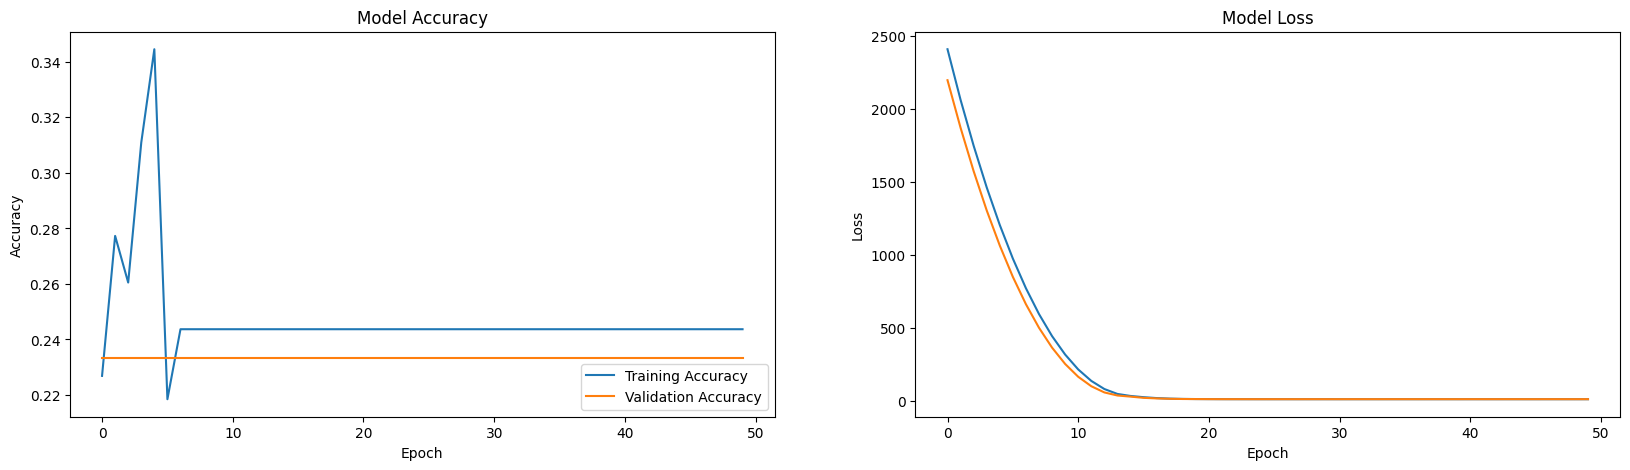

Text(0.5, 0, 'Performance Metric')

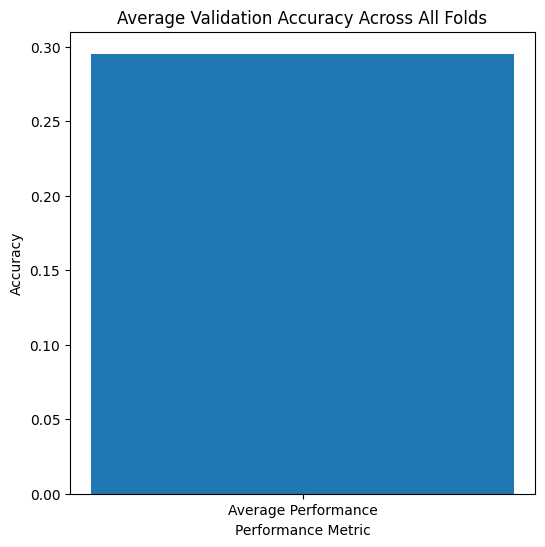

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

    plt.show()


print("val_accuracy: ", history.history['val_accuracy'])
print("accuracy: ", history.history['accuracy'])
print("val_loss: ", history.history['val_loss'])
print("loss: ", history.history['loss'])

plot_history(history)
#plot_history(hypermodel_history)

plt.figure(figsize=(6, 6))
plt.bar(['Average Performance'], [average_performance])
plt.title('Average Validation Accuracy Across All Folds')
plt.ylabel('Accuracy')
plt.xlabel('Performance Metric')

In [ ]:
from tensorflow.keras.layers import Embedding

# Assuming num_categories is the number of unique classifications
output_embedding = Embedding(input_dim=num_categories, output_dim=embedding_size)(input_layer)

# Then, connect this to a Dense layer with a softmax activation for multi-class classification
model.add(Dense(num_categories, activation='softmax'))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import keras.tuners as kt

# Assuming X_train, y_train, X_val, and y_val are defined and prepared

# Define a function for RFE
def rfe_selector(X, y, n_features_to_select=10):
    """
    Perform Recursive Feature Elimination.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - n_features_to_select: Number of features to select
    
    Returns:
    - Selected features indices
    """
    estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
    selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(X, y)

    print("Feature Ranking:")
    for rank, feature in zip(selector.ranking_, X.columns):
        print(f"Feature: {feature}, Rank: {rank}")
    
    return selector.support_

# Example of using RFE to select features
selected_features = rfe_selector(X_train, y_train, n_features_to_select=10)

# Use the selected features to train your model
X_train_selected = X_train[:, selected_features]
X_val_selected = X_val[:, selected_features]

# Define your model builder function
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train_selected[0].shape))
    
    hp_units = hp.Int('units', min_value=16, max_value=1024, step=32)
    hp_layers = hp.Int('layers', min_value=2, max_value=15, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    hp_regularization = hp.Choice('regularization', values=['l1', 'l2', 'l1_l2'])
    hp_lambda = hp.Float('lambda', min_value=0.0, max_value=1.0, step=0.01)
    
    for _ in range(hp_layers):
        if hp_regularization == 'l1':
            regularizer = tf.keras.regularizers.l1(hp_lambda)
        elif hp_regularization == 'l2':
            regularizer = tf.keras.regularizers.l2(hp_lambda)
        else: # l1_l2
            regularizer = tf.keras.regularizers.l1_l2(l1=hp_lambda, l2=hp_lambda)
        
        model.add(tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizer))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(len(np.unique(y_train)) + 1, activation='softmax'))

    optimizer = hp_optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=3,
    directory='trained_models',
    project_name='DI_8'
)

# Search for the best hyperparameters
tuner.search(X_train_selected, y_train, epochs=50, validation_data=(X_val_selected, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
eval_result = best_model.evaluate(X_val_selected, y_val)
print("[test loss, test accuracy]:", eval_result)

# Save the best model
best_model_path = r'trained_models\best_model\best_model.keras'
best_model.save(best_model_path)

# Load the best model for further use
best_model = keras.models.load_model(best_model_path)

# Example of using the best model for prediction
 test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
 print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
